In [1]:
!git clone -b Test_L1 --single-branch https://github.com/whiskycasablanca/CLIP_Implementation.git

Cloning into 'CLIP_Implementation'...
remote: Enumerating objects: 8173, done.
remote: Counting objects: 100% (9/9), done.
remote: Total 8173 (delta 8), reused 8 (delta 8), pack-reused 8164 (from 1)
Receiving objects: 100% (8173/8173), 1.03 GiB | 24.74 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Updating files: 100% (8114/8114), done.


In [3]:
import os
os.chdir('/content/CLIP_Implementation')

In [9]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer
from CLIP import CLIPModel  # models.py 내의 CLIPModel
import torchvision.transforms as T
from dataset import Flickr8kDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
# 토크나이저와 이미지 전처리 정의
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                std=[0.26862954, 0.26130258, 0.27577711])
])

# split된 데이터셋 생성성
split_files = {'train' : 'Flickr_8k.trainImages.txt', 'validation' : 'Flickr_8k.devImages.txt', 'test' : 'Flickr_8k.testImages.txt'}
datasets = {
    split_name : Flickr8kDataset(
        img_folder='images',
        caption_file='captions.txt',
        split_file=split_file,  # 분할 파일 경로 지정
        transform=transform,  # 미리 정의한 transform
        tokenizer=tokenizer ,  # 미리 정의한 토크나이저
        max_length=40
    )
    for split_name, split_file in split_files.items()
}

In [7]:
# 디바이스 지정
device = "cuda" if torch.cuda.is_available() else "cpu"

# DataLoader 생성
train_loader = DataLoader(datasets['train'], batch_size=32, shuffle=False, num_workers=4)
val_loader = DataLoader(datasets['validation'], batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(datasets['test'], batch_size=32, shuffle=False, num_workers=4)

# CLIP 모델 생성
model = CLIPModel()

# Optimizer 생성
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 168MB/s]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [10]:
# 학습 진행
num_epochs = 5  # 원하는 에폭 수
best_val_loss = float('inf')

# 손실 기록용 리스트
train_loss_history = []
val_loss_history = []

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    step = 0

    # tqdm progress bar로 학습 배치 진행 상황 표시
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for batch in pbar:
        step += 1
        # 배치 데이터를 디바이스로 이동
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        masks = batch["mask"].to(device)

        inputs = {
            "image": images,
            "input_ids": input_ids,
            "mask": masks
        }

        optimizer.zero_grad()

        loss = model(inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # 10 스텝마다 현재 Loss 출력
        if step % 1 == 0:
            pbar.set_postfix({"Loss": loss.item()})

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(epoch_train_loss)

    # 검증 루프
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            masks = batch["mask"].to(device)

            inputs = {
                "image": images,
                "input_ids": input_ids,
                "mask": masks
            }

            loss = model(inputs)
            running_val_loss += loss.item() * images.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_loss_history.append(epoch_val_loss)

    print(f"\nEpoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # 검증 손실이 개선되면 모델 저장
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), "best_clip_model.pth")
        print("Best model saved!")

Epoch [1/5]: 100%|██████████| 188/188 [01:20<00:00,  2.34it/s, Loss=2.21]



Epoch [1/5] Train Loss: 3.3960, Val Loss: 2.7220
Best model saved!


Epoch [2/5]: 100%|██████████| 188/188 [01:22<00:00,  2.27it/s, Loss=1.81]



Epoch [2/5] Train Loss: 2.5280, Val Loss: 2.1926
Best model saved!


Epoch [3/5]: 100%|██████████| 188/188 [01:22<00:00,  2.27it/s, Loss=1.11]



Epoch [3/5] Train Loss: 2.1553, Val Loss: 2.0029
Best model saved!


Epoch [4/5]: 100%|██████████| 188/188 [01:23<00:00,  2.26it/s, Loss=0.913]



Epoch [4/5] Train Loss: 1.9581, Val Loss: 1.8495
Best model saved!


Epoch [5/5]: 100%|██████████| 188/188 [01:23<00:00,  2.26it/s, Loss=0.74]



Epoch [5/5] Train Loss: 1.7857, Val Loss: 1.7995
Best model saved!


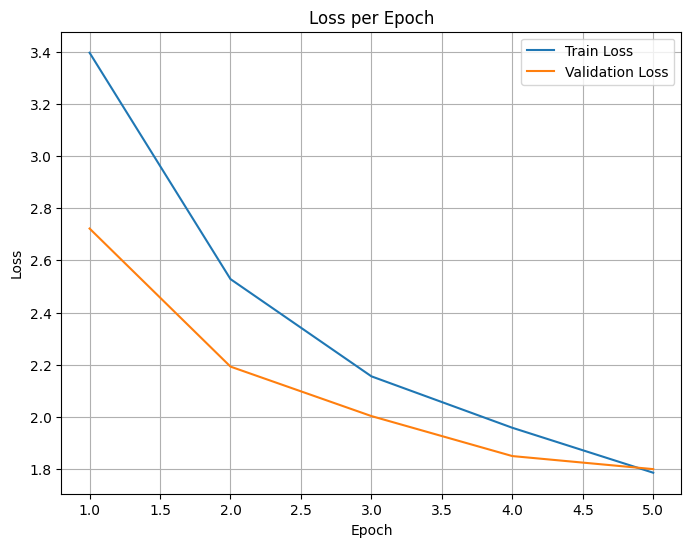

In [11]:
# 학습/검증 손실 변화를 그래프로 출력
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_loss_history, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# 테스트 루프: 저장된 모델을 로드해서 평가
model.load_state_dict(torch.load("best_clip_model.pth"))
model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        masks = batch["mask"].to(device)

        inputs = {
            "image": images,
            "input_ids": input_ids,
            "mask": masks
        }
        loss = model(inputs)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

<ipython-input-12-f35ab7e2e0d3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_clip_model.pth"))


Test Loss: 1.8163
